In [7]:
!pwd
isLocalServer = True

/notebook/personal/ksuchoi216/face-id-model


In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, os, sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()

def path_add_to_sys_path(path_to_be_add):
  # path_to_be_add = '/notebook/personal/ksuchoi216/face-id-model/'
  if not path_to_be_add in sys.path:
    sys.path.insert(0, path_to_be_add)
    os.chdir(path_to_be_add)

  print(f'sys.path: {sys.path}')

if isLocalServer is True:
  path_add_to_sys_path('/notebook/personal/ksuchoi216/face-id-model/')
  
from utils import load_config
cfg = load_config('config_pca.json')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sys.path: ['/notebook/personal/ksuchoi216/face-id-model/', '/notebook', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython']


# Loading model and data

250
 data 
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
batch_size: 1 

dataset length: (1079) = tr (863) + val (107) + tt (109)


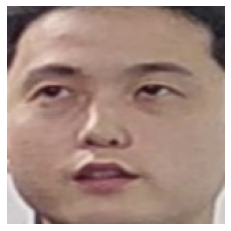

label: 3


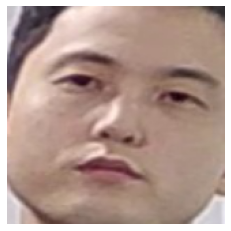

label: 3


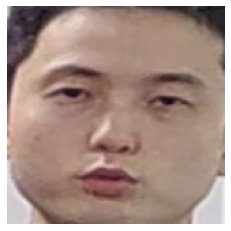

label: 3


In [16]:
from datasets import Folder_Dataset
from utils import imshow_dataloader

folder_Dataset = Folder_Dataset(cfg['embedding'])
dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

phase="train"
for i, (img, label) in enumerate(dataloaders[phase]):
  if i >= 3:
    break
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print(f'label: {label}')  

In [17]:
from modules import Builder
import torchsummary

builder = Builder(cfg['model'])
model = builder.loadModel('./data/face-extraction-model.pt', 'cpu', classify=False)

device is cuda:0
Loading model was just completed.


# Feature extraction and data transfromation

In [54]:
from external_library import MTCNN
face_detector = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40)


from utils import imshow_denormalization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# phases = ['train', 'val', 'test']
phases = ['train']
for phase in phases:
  print(f'phase: {phase}')
  
  
  image_list = []
  embedding_list = []
  label_list = []
  
  for i, (img, label) in enumerate(dataloaders[phase]):
    face, prob = face_detector(img, return_prob = True)
    if face is not None:
      embedding = model(face)
      embedding = torch.squeeze(embedding).numpy()

      face = torch.reshape(torch.squeeze(face), (-1, )).numpy()
      # print(f'face shape: {face.shape}')
      image_list.append(face)
      
      # print(f'embedding: {embedding.shape} {type(embedding)} label: {label} {type(label)}')  
      if embedding.shape[0] != 512:
        print(f'dimension errror - embedding.shape: {embedding.shape[0]}')
      embedding_list.append(embedding)
      
      label_list.append(label)
  
    print(f'{i:4}...')  
    # if i >= 2:
      # break
  
  path_for_image_data = './data/'+phase+'_image.npy'
  path_for_embedding_data = './data/'+phase+'_embedding.npy'
  path_for_label_data = './data/'+phase+'_label.npy'
  
  image_numpy = np.array(image_list)
  embedding_numpy = np.array(embedding_list)
  label_numpy = np.array(label_list)
  
  np.save(path_for_image_data, image_numpy, allow_pickle=True)
  np.save(path_for_embedding_data, embedding_numpy, allow_pickle=True)
  np.save(path_for_label_data, label_numpy, allow_pickle=True)
  # print(len(data_list))
  print(f'{phase}_image.npy saved in {path_for_image_data}')
  print(f'{phase}_embedding.npy saved in {path_for_embedding_data}')
  print(f'{phase}_label.npy saved in {path_for_label_data}')
  
  print('\n')  

phase: train
   0...
   1...
   2...
   3...
   4...
   5...
   6...
   7...
   8...
   9...
  10...
  11...
  12...
  13...
  14...
  15...
  16...
  17...
  18...
  19...
  20...
  21...
  22...
  23...
  24...
  25...
  26...
  27...
  28...
  29...
  30...
  31...
  32...
  33...
  34...
  35...
  36...
  37...
  38...
  39...
  40...
  41...
  42...
  43...
  44...
  45...
  46...
  47...
  48...
  49...
  50...
  51...
  52...
  53...
  54...
  55...
  56...
  57...
  58...
  59...
  60...
  61...
  62...
  63...
  64...
  65...
  66...
  67...
  68...
  69...
  70...
  71...
  72...
  73...
  74...
  75...
  76...
  77...
  78...
  79...
  80...
  81...
  82...
  83...
  84...
  85...
  86...
  87...
  88...
  89...
  90...
  91...
  92...
  93...
  94...
  95...
  96...
  97...
  98...
  99...
 100...
 101...
 102...
 103...
 104...
 105...
 106...
 107...
 108...
 109...
 110...
 111...
 112...
 113...
 114...
 115...
 116...
 117...
 118...
 119...
 120...
 121...
 122...
 12

In [58]:
phase = phases[0]

source = './data/'
path_x_img = source + phase + '_image.npy'
x_img = np.load(path_x_img, allow_pickle=True)


path_x_emb = source + phase +'_embedding.npy'
x_emb = np.load(path_x_emb, allow_pickle=True)

path_y = source + phase + '_label.npy'
y = np.load(path_y, allow_pickle=True)

# val_path = source + 'val.npy'
# test_path = source + 'test.npy'


print(f'images shape: {x_img.shape} embedding: {x_emb.shape} y: {y.shape}')

images shape: (863, 172800) embedding: (863, 512) y: (863,)


# PCA

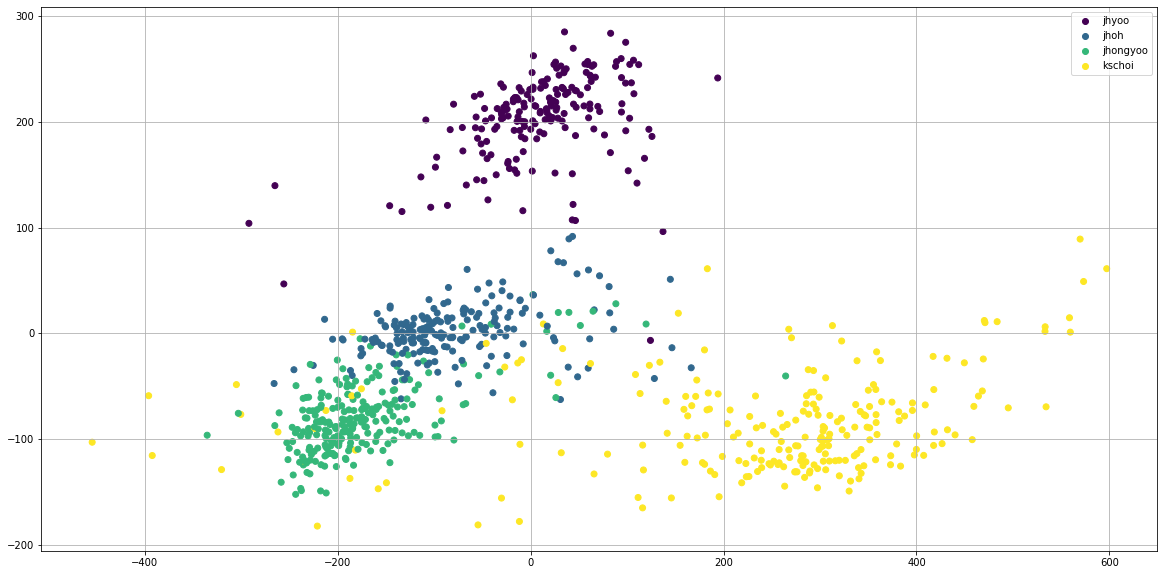

In [59]:
from utils import show_pca
label_list = ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi']
show_pca(x_img, y, label_list)

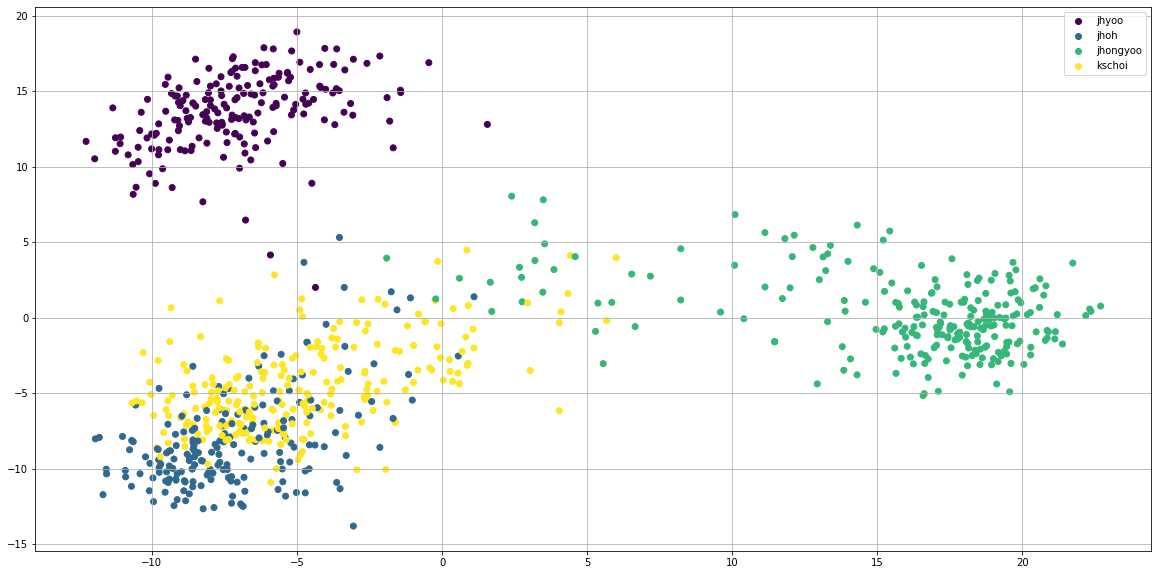

In [60]:
from utils import show_pca
label_list = ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi']
show_pca(x_emb, y, label_list)